### Import libraries

In [ ]:
import random

import numpy as np
from skimage.transform import resize

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Load MNIST

In [ ]:

mnist_img_height , mnist_img_width = 28 , 28
(x_train,y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [ ]:
print(f"Number of train images:{x_train.shape[0]}")
print(f"Number of test images:{x_test.shape[0]}")

Number of train images:60000
Number of test images:10000


### Build two-digit mnist sequences 

In [ ]:
def build_sequence_mnist(data,labels,dataset_size,IS_TRAIN=True):
    
    # sequence data size
    seq_img_height = 64
    seq_img_width = 64
    
    seq_data = np.ndarray(shape=(dataset_size,seq_img_height,seq_img_width),
                           dtype=np.float32)
    seq_labels = [] 
    
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        # num_digits = random.randint(1,2)
        
        s_indices = [random.randint(0,len(data)-1) for p in range(0,2)]

        if IS_TRAIN:
          # concatenating images and labels together
          new_image = np.hstack([x_train[index] for index in s_indices])
          new_label =  [y_train[index] for index in s_indices]
        else:

          new_image = np.hstack([x_test[index] for index in s_indices])
          new_label =  [y_test[index] for index in s_indices]
        
        
        #Resize image
        new_image = resize(new_image,(seq_img_height,seq_img_width))
        
        seq_data[i,:,:] = new_image
        seq_labels.append(tuple(new_label))
        
    
    #Return the synthetic dataset
    return seq_data,seq_labels


In [ ]:
x_seq_train,y_seq_train = build_sequence_mnist(x_train,y_train,60000)
x_seq_test,y_seq_test = build_sequence_mnist(x_test,y_test,10000,IS_TRAIN=False)

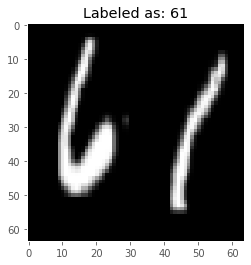

In [ ]:
RANDOM_IMG_TO_SHOW = 2
plt.figure()
plt.imshow(x_seq_test[RANDOM_IMG_TO_SHOW], cmap='gray')
plt.title("Labeled as: {}".format(''.join(str(i) for i in y_seq_test[RANDOM_IMG_TO_SHOW])))
plt.grid(b=None)
plt.show()

### One-Hot encoding

In [ ]:
#Converting labels to One-hot representations of shape (set_size,digits,classes)
possible_classes = 10

def convert_labels(labels):
        
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))

    
    for index,label in enumerate(labels):
        
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        
    return [dig0_arr,dig1_arr]

In [ ]:
train_labels = convert_labels(y_seq_train)
test_labels = convert_labels(y_seq_test)

In [ ]:
np.shape(test_labels[0])

(10000, 10)

### Second Model --> LRCN (CNN-LSTM)

In [ ]:
from keras import  applications
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Lambda

nb_classes = 10

img_rows = 64
img_cols = 64
img_channels = 1

#number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

#defining the input
inputs = Input(shape=(None,img_rows,img_cols,img_channels))

#Model taken from keras example. Worked well for a digit, dunno for multiple
cov = TimeDistributed(Conv2D(nb_filters,kernel_size,padding='same'))(inputs)
cov = TimeDistributed(Activation('relu'))(cov)
cov = TimeDistributed(BatchNormalization())(cov)
cov = TimeDistributed(Conv2D(nb_filters,kernel_size))(cov)
cov = TimeDistributed(Activation('relu'))(cov)
cov = TimeDistributed(BatchNormalization())(cov)
cov = TimeDistributed(MaxPooling2D(pool_size=pool_size))(cov)
cov = TimeDistributed(Dropout(0.25))(cov)
cov_out = TimeDistributed(Flatten())(cov)

# return_sequences = true -> to share output of lstm to all dense layers
encoded_vid = LSTM(64,return_sequences=True)(cov_out)
encoded_vid = TimeDistributed(Dense(32, activation='relu'))(encoded_vid)
encoded_vid = Dropout(0.25)(encoded_vid)

#Prediction layers
c0 = TimeDistributed(Dense(nb_classes, activation='softmax'),name='digit1')(encoded_vid)
c1 = TimeDistributed(Dense(nb_classes, activation='softmax'),name='digit2')(encoded_vid)

model = Model(inputs=[inputs],outputs=[c0,c1], name='custom-cnn-lstm')
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "custom-cnn-lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 64, 64, 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 64, 64, 320         input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 64, 64, 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, None, 64, 64, 128         time_distributed_2[0][0]         
____________________________________________________________________________________

### Prepare Data

In [ ]:
def prep_data_keras(img_data):
    
    ### 10 refers to time_steps
    img_data = img_data.reshape(len(img_data)//10,10,64,64,1)
    img_data = img_data.astype('float32')
    img_data /= 255.0
    
    return img_data

train_images = prep_data_keras(x_seq_train)
test_images = prep_data_keras(x_seq_test)
print(f"Test Image Shape: {test_images.shape}")

Train Image Shape: (1000, 10, 64, 64, 1)


In [ ]:
train_labels[0] = train_labels[0].reshape(6000,10,10)
train_labels[1] = train_labels[1].reshape(6000,10,10)

### Define callbacks and call model.fit()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import numpy as np

save_dir = 'two-digit-custom-model-test3-with-cnn-lstm.h5'
model_checkpoint = ModelCheckpoint(save_dir, 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')

lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))

early = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
                      
hist = model.fit(train_images,train_labels,batch_size=32,epochs=50,verbose=2,validation_split=0.2, callbacks=[model_checkpoint, lr_sched, early])

Train on 4800 samples, validate on 1200 samples
Epoch 1/50
 - 47s - loss: 2.9499 - digit1_loss: 1.4665 - digit2_loss: 1.4833 - digit1_acc: 0.5384 - digit2_acc: 0.5351 - val_loss: 4.5822 - val_digit1_loss: 2.2911 - val_digit2_loss: 2.2911 - val_digit1_acc: 0.2533 - val_digit2_acc: 0.1524

Epoch 00001: val_loss improved from inf to 4.58222, saving model to two-digit-custom-model-test3-with-cnn-lstm.h5
Epoch 2/50
 - 40s - loss: 2.0619 - digit1_loss: 1.0101 - digit2_loss: 1.0518 - digit1_acc: 0.7265 - digit2_acc: 0.7059 - val_loss: 4.5332 - val_digit1_loss: 2.2676 - val_digit2_loss: 2.2655 - val_digit1_acc: 0.1525 - val_digit2_acc: 0.1780

Epoch 00002: val_loss improved from 4.58222 to 4.53317, saving model to two-digit-custom-model-test3-with-cnn-lstm.h5
Epoch 3/50
 - 40s - loss: 1.6838 - digit1_loss: 0.8255 - digit2_loss: 0.8583 - digit1_acc: 0.7893 - digit2_acc: 0.7754 - val_loss: 4.3148 - val_digit1_loss: 2.1575 - val_digit2_loss: 2.1573 - val_digit1_acc: 0.1667 - val_digit2_acc: 0.177

### Model Visualization

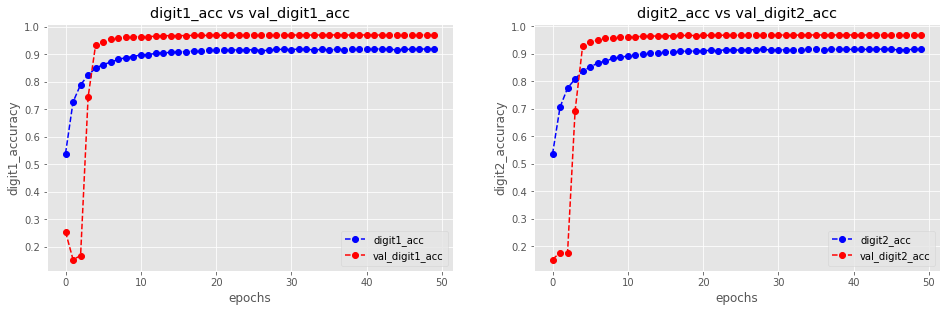

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(16,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(hist.history['digit1_acc'],'bo--', label = "digit1_acc")
    plt.plot(hist.history['val_digit1_acc'], 'ro--', label = "val_digit1_acc")
    plt.title("digit1_acc vs val_digit1_acc")
    plt.ylabel("digit1_accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(hist.history['digit2_acc'],'bo--', label = "digit2_acc")
    plt.plot(hist.history['val_digit2_acc'], 'ro--', label = "val_digit2_acc")
    plt.title("digit2_acc vs val_digit2_acc")
    plt.ylabel("digit2_accuracy")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
  
plot_accuracy_loss(hist)

### Save model weights

In [ ]:
!cp two-digit-custom-model-test3-with-cnn-lstm.h5 drive/My\ Drive/mnist-generator/.

### Load Model

In [ ]:
!cp drive/My\ Drive/mnist-generator/two-digit-custom-model-test2-with-batchnormalization.h5 .

In [ ]:
model.load_weights('two-digit-custom-model-test2-with-batchnormalization.h5')

### Evaluate model on test

In [ ]:
test_labels[0] = test_labels[0].reshape(1000,10,10)
test_labels[1] = test_labels[1].reshape(1000,10,10)

In [ ]:
scores = model.evaluate(test_images, test_labels)
print(f"First digit accuracy: {scores[3]} , Second digit accuracy: {scores[4]}")

1000/1000 [==============================] - 3s 3ms/step
First digit accuracy: 0.9678999781608582 , Second digit accuracy: 0.9670000076293945


### Model Inference

In [ ]:
#Printing some examples of real and predicted labels
predictions = model.predict(test_images)
predictions[0] = predictions[0].reshape(10000,10)
predictions[1] = predictions[1].reshape(10000,10)
test_labels[0] = test_labels[0].reshape(10000,10)
test_labels[1] = test_labels[1].reshape(10000,10)

for i in random.sample(range(0,10000),50):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,2):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [3, 3]
Predicted labels: [3, 3]

Actual labels: [9, 3]
Predicted labels: [9, 3]

Actual labels: [5, 3]
Predicted labels: [5, 3]

Actual labels: [4, 8]
Predicted labels: [4, 8]

Actual labels: [3, 1]
Predicted labels: [3, 1]

Actual labels: [4, 1]
Predicted labels: [4, 1]

Actual labels: [4, 9]
Predicted labels: [4, 9]

Actual labels: [7, 8]
Predicted labels: [7, 8]

Actual labels: [5, 4]
Predicted labels: [5, 4]

Actual labels: [7, 1]
Predicted labels: [7, 1]

Actual labels: [7, 9]
Predicted labels: [7, 9]

Actual labels: [7, 4]
Predicted labels: [7, 4]

Actual labels: [7, 7]
Predicted labels: [7, 2]

Actual labels: [9, 4]
Predicted labels: [9, 4]

Actual labels: [0, 1]
Predicted labels: [0, 1]

Actual labels: [8, 1]
Predicted labels: [8, 1]

Actual labels: [4, 8]
Predicted labels: [4, 8]

Actual labels: [7, 7]
Predicted labels: [7, 7]

Actual labels: [2, 5]
Predicted labels: [2, 5]

Actual labels: [4, 5]
Predicted labels: [4, 5]

Actual labels: [7, 0]
Predicted labels: 